# Grab spectograms from the H5 files, resize them to the first 100 ms but leave them as 2D arrays. 
## stick them in a np.array (X) and save it.
## Then we're going to analyze them in another notebook (potentially)
## that might involve doing PCA to them, UMAP that, and plot the results. May as well cluster them too.
## the plan is to use a neural network though

## Assume we have a folder with calls as .wav files (from soundsep)
## Produce a bunch of spectrograms for clustering. Probably do PCA, we'll see

In [1]:
# from scipy import integrate, optimize

import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

In [2]:
desired_length = 100 # in ms # change if you want to play with this- all files will be truncated to this length or padded with zeros

base_folder = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023'
wav_list = [f for f in os.listdir(os.path.join(base_folder,'wavs')) if f.endswith('.wav')]
# find the shortest file and the longest file but this isn't really necessary
# print(f'number of files: {len(wav_list)}')
wav_lengths = [read(os.path.join(base_folder,'wavs',f))[1].shape[0] for f in wav_list]  
shortest_file = wav_list[np.argmin(wav_lengths)]
# longest_file = wav_list[np.argmax(wav_lengths)]
# print(f' shortest file: {shortest_file} \n longest file: {longest_file}')
# # read the shortest file
fs, data = read(os.path.join(base_folder,'wavs', shortest_file))
# print(f'fs: {fs} \n data shape: {data.shape}, length: {data.shape[0]/fs} seconds')
# # read the longest file
# fs, data = read(os.path.join(base_folder,'wavs',longest_file))
# print(f'fs: {fs} \n data shape: {data.shape}, length: {data.shape[0]/fs} seconds')
print(f'fs = {fs} Hz, desired length = {desired_length} ms')
# desired_length = int(desired_length * fs) # in data points
# print(f'desired length: {desired_length} data points')


fs = 48000 Hz, desired length = 100 ms


In [3]:
# Wait I can do this in the H5 files
os.chdir(os.path.join(base_folder,'h5filesAmp'))
h5_files = [f for f in os.listdir() if f.endswith('.h5')]

tableStore = os.path.join(base_folder,'spec_results','vocSelTableSprectro.h5')
pcInfo = os.path.join(base_folder,'spec_results','vocSpectroPC.pkl')


## check the size of our spectrograms, verify they all have the same frequency bins (just errors if they don't)
## then just take the firs 100 ms (desired_length) of time bins and put them all in a np.array for sorting


In [4]:
# Verify the size our spectrograms will be
# Set true if you want to normalize all spectrograms.
normFlg = True
#nPCs is the number of PCs that will be used in the first dimensionality reduction
nPCs = 50
# Read the files to allocate space for np array
count = 0
shapeSpectro = []
birdName = []
callType = []
lengths = list()
for fname in h5_files:
    myBioSound = BioSound()
    myBioSound.readh5(fname)
    lengths.append(len(myBioSound.sound))
    shapeSpectro.append(myBioSound.spectro.shape)
    # print(f'spectrogram shapes: {shapeSpectro[-1]}')
    birdName.append(np.array2string(myBioSound.emitter)[2:-1])
    callType.append(np.array2string(myBioSound.type)[2:-1])
    count += 1

shapeSpectro.sort()

num_freq_bins = [shape[0] for shape in shapeSpectro]
if len(np.unique(num_freq_bins)) > 1:
    print(f'WARNING: calls are not all the same length')  
    print(f'frequncy bins: {np.unique(num_freq_bins)}')
else:
    print(f'All spectrograms have {num_freq_bins[0]} frequency bins')
    num_freq_bins = num_freq_bins[0]
print(f'time bins are {myBioSound.to[1]-myBioSound.to[0]} ms')
num_time_bins = int((desired_length/1000)/(myBioSound.to[1]-myBioSound.to[0]))
print(f'We will be taking {num_time_bins} time bins')
print(f'Allocating space for {count} spectrograms, shape: {count} x {num_freq_bins} x {num_time_bins}')
X = np.zeros((count, num_freq_bins, num_time_bins))
time_bins = myBioSound.to[0:num_time_bins]
freq_bins = myBioSound.fo

All spectrograms have 101 frequency bins
time bins are 0.001 ms
We will be taking 100 time bins
Allocating space for 4344 spectrograms, shape: 4344 x 101 x 100


In [5]:
#plot a histogram of lengths of spectrograms
# you only need to do this if you're interested in what a good spectrogram lenght for your particular data is: I am goign to go with 100 ms for now

# plt.hist([s[1] for s in shapeSpectro], bins=100)
# plt.xlabel('Length of spectrogram')
# plt.ylabel('Number of spectrograms')
# plt.title('Histogram of lengths of spectrograms')
# # print the mode
# print(f'Mode of spectrogram lengths: {Counter([s[1] for s in shapeSpectro]).most_common(1)}')

# # plot a histogram of lengths of calls
# plt.figure()
# plt.hist(lengths, bins=100)
# plt.xlabel('Length of call')
# plt.ylabel('Number of calls')
# plt.title('Histogram of lengths of calls')
# # print the mode
# print(f'Mode of call lengths: {Counter(lengths).most_common(1)}')
  


In [6]:
# check all the spectrogram shapes and adjust them to the desired length
for i, file in enumerate(h5_files):
    myBioSound = BioSound()
    myBioSound.readh5(file)
    if myBioSound.spectro.shape[1] < num_time_bins:
        myBioSound.spectro = np.pad(myBioSound.spectro, ((0,0),(0,num_time_bins-myBioSound.spectro.shape[1])), 'constant')
        X[i,:,:] = myBioSound.spectro
    elif myBioSound.spectro.shape[1] > num_time_bins: # if it's longer than desired, truncate it taking the first num_time_bins, TODO take the center of the syllable instead or make it optional
        X[i,:,:] = myBioSound.spectro[:,:num_time_bins]
    else:
        X[i,:,:] = myBioSound.spectro

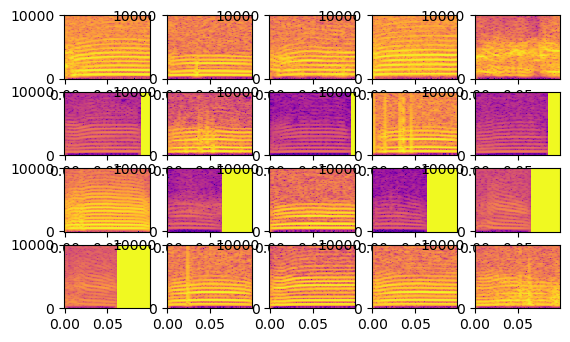

In [7]:
# you can plot a couple of the spectograms to make sure they look ok by changing the index
index = 60
plt.figure()
plt.subplot(5,5,1)
plt.pcolormesh(time_bins, freq_bins, X[index,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,2)
plt.pcolormesh(time_bins, freq_bins, X[index+1,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,3)
plt.pcolormesh(time_bins, freq_bins, X[index+2,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,4)
plt.pcolormesh(time_bins, freq_bins, X[index+3,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,5)
plt.pcolormesh(time_bins, freq_bins, X[index+4,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,6)
plt.pcolormesh(time_bins, freq_bins, X[index+5,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,7)
plt.pcolormesh(time_bins, freq_bins, X[index+6,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,8)
plt.pcolormesh(time_bins, freq_bins, X[index+7,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,9)
plt.pcolormesh(time_bins, freq_bins, X[index+8,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,10)
plt.pcolormesh(time_bins, freq_bins, X[index+9,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,11)
plt.pcolormesh(time_bins, freq_bins, X[index+10,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,12)
plt.pcolormesh(time_bins, freq_bins, X[index+11,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,13)
plt.pcolormesh(time_bins, freq_bins, X[index+12,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,14)
plt.pcolormesh(time_bins, freq_bins, X[index+13,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,15)
plt.pcolormesh(time_bins, freq_bins, X[index+14,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,16)
plt.pcolormesh(time_bins, freq_bins, X[index+15,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,17)
plt.pcolormesh(time_bins, freq_bins, X[index+16,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,18)
plt.pcolormesh(time_bins, freq_bins, X[index+17,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,19)
plt.pcolormesh(time_bins, freq_bins, X[index+18,:,:], cmap='plasma', shading='auto')
plt.subplot(5,5,20)
plt.pcolormesh(time_bins, freq_bins, X[index+19,:,:], cmap='plasma', shading='auto')
plt.show()




In [8]:
# save the spectrograms to a file
# np.save(os.path.join(base_folder,'spec_results','spectrograms.npy'), X)


## do a quick pca and umap or tsne, maybe cluster too, let's see where we get
## While we made sure to keep our spectrograms the same size (2D), we now flatten them for the below analysis
## The 2D specs are for 1) visualization and 2) NNs

Shape of Z_PCA_All: (4344, 10)


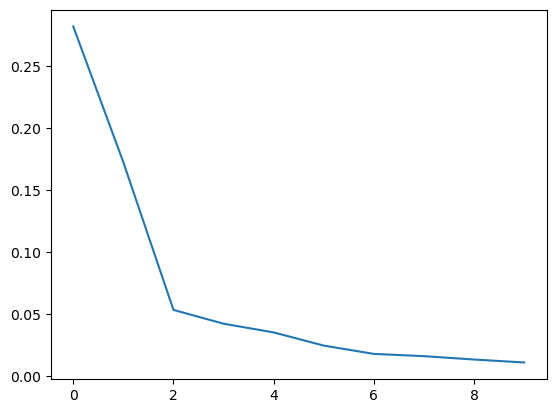

In [9]:
cleanX = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
# Zscore the data
meanBalancedAll = np.mean(cleanX, axis = 0)
sdBalancedAll = np.std(cleanX, axis = 0, ddof=1)
ZBalancedAll = (cleanX - meanBalancedAll)/sdBalancedAll

# PCA the data
pcaBalanced = PCA(n_components=10, svd_solver='full')
Z_PCA_Balanced_All = pcaBalanced.fit_transform(ZBalancedAll)

print("Shape of Z_PCA_All:", Z_PCA_Balanced_All.shape)

# Plot the explainable variance
plt.plot(pcaBalanced.explained_variance_ratio_)

(4344, 10)


Text(0.5, 1.0, 'PCA of the data, balanced and zscored, 10 components, 2 dimensions')

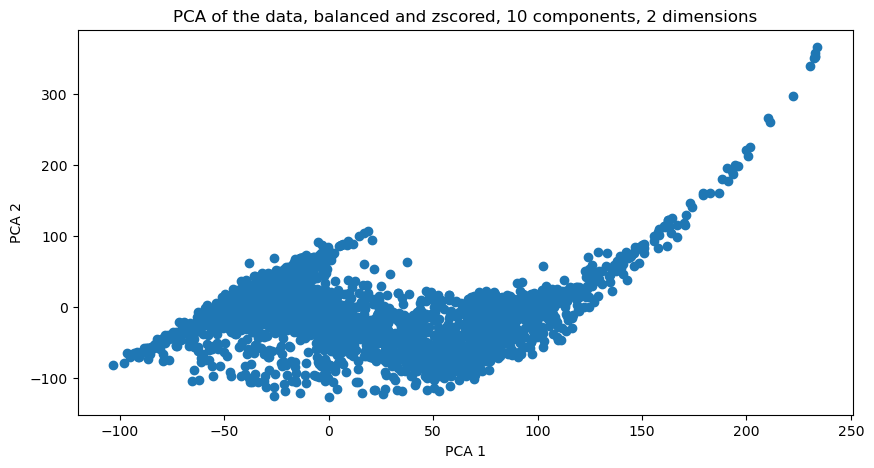

In [10]:
print(Z_PCA_Balanced_All.shape)
# Plot the first two components
plt.figure(figsize=(10, 5))
plt.scatter(Z_PCA_Balanced_All[:,0], Z_PCA_Balanced_All[:,1], cmap = 'tab20')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of the data, balanced and zscored, 10 components, 2 dimensions')

In [11]:
MAXSYLL = 40
umapFit = umap.UMAP(
        n_neighbors=int(len(Z_PCA_Balanced_All)/MAXSYLL),
        min_dist=0.1,
        n_components=3,
        random_state=42).fit(Z_PCA_Balanced_All)

umapAll = umapFit.transform(Z_PCA_Balanced_All)

/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [12]:
# Let's cluster the UMAP data so we have colors to look at
# HDBSCAN
min_cluster_size = 15
min_samples = 15
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
clusterer.fit(umapAll)

HDBSCAN(min_cluster_size=15, min_samples=15)

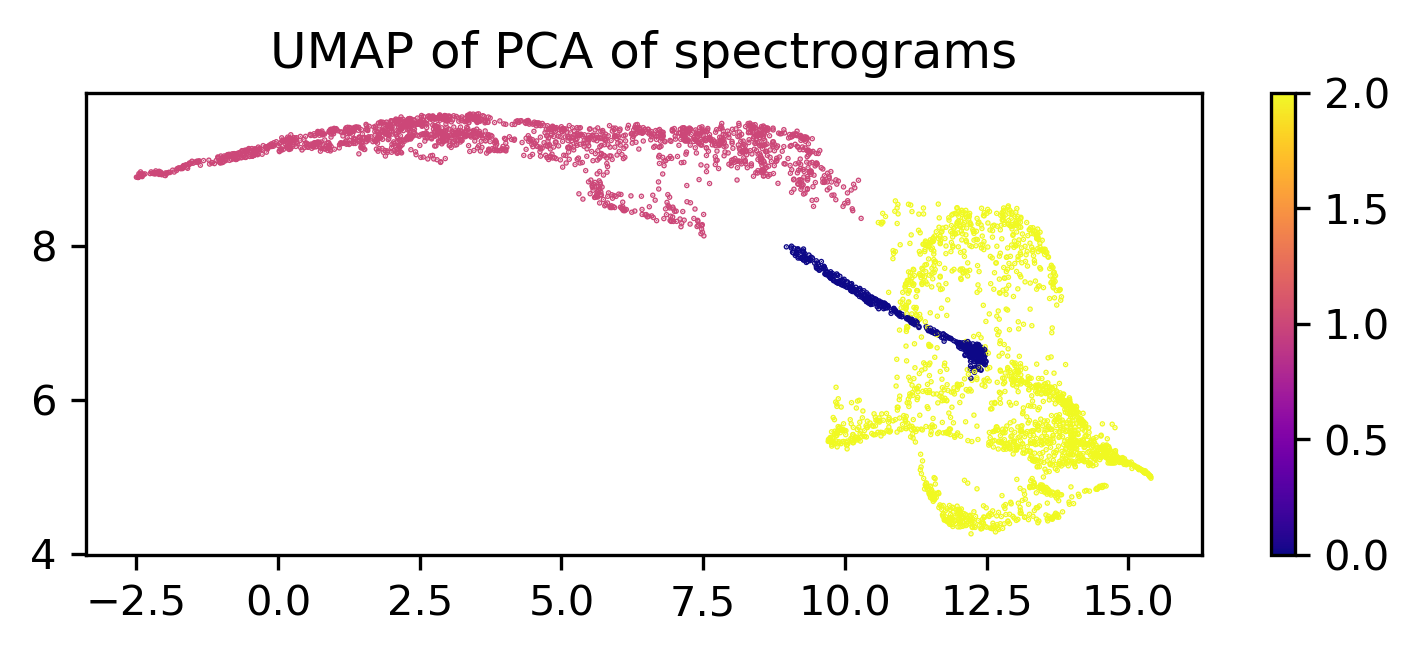

In [13]:

plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='plasma')
plt.title('UMAP of PCA of spectrograms')
plt.colorbar()

Text(0.5, 1.0, 'UMAP of PCA of spectrograms, cluster 2')

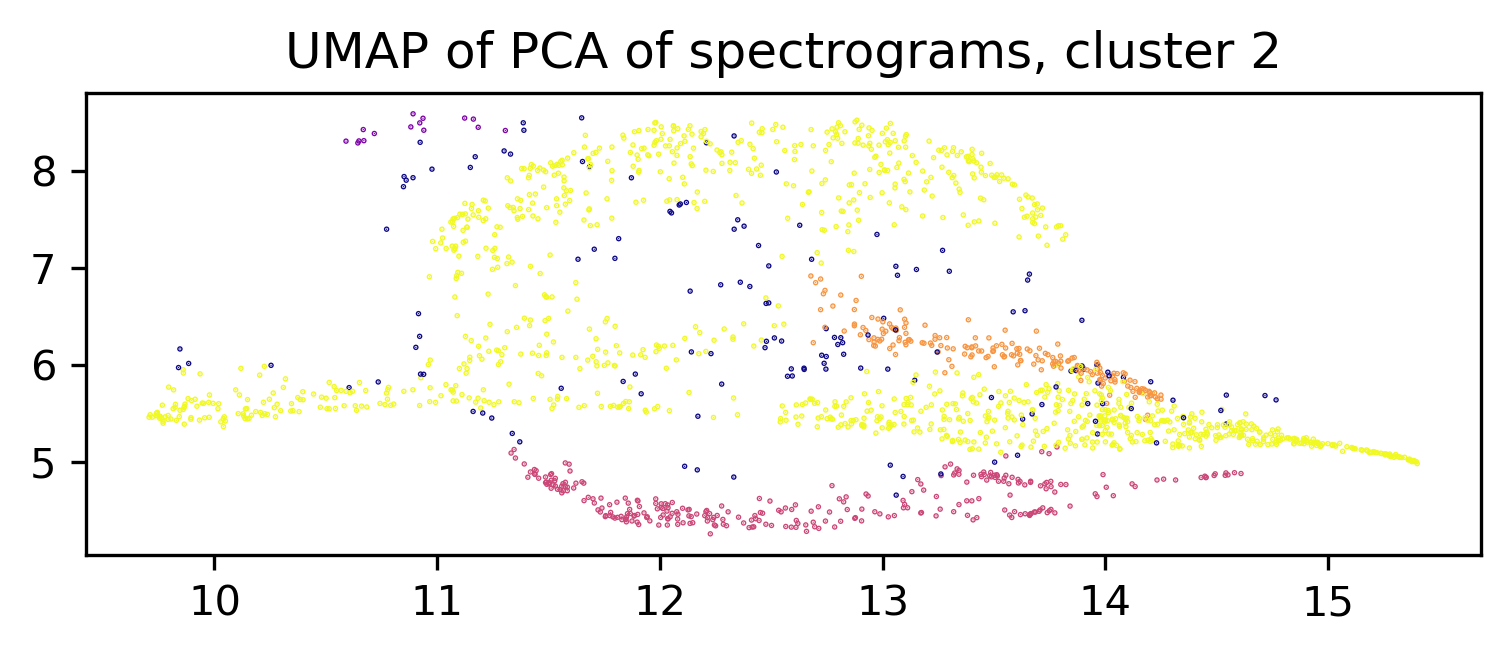

In [14]:
# let's try subclustering some of the data. Cluster 2 looks like it has a lot of stuff in it
# recluster cluster 2
subCluster = 2
subClusterInd = np.where(clusterer.labels_ == subCluster)
subClusterData = Z_PCA_Balanced_All[subClusterInd]
subClusterUMAP = umapAll[subClusterInd] # this is the UMAP data for the subcluster, we will use this for visualization but we will cluster the PCA data

# NOTE THIS IS HARDCODED and may not always work with cluster_selection_epsilon = .35
subClusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10, cluster_selection_epsilon=.35)

subClusterer.fit(subClusterUMAP)
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(subClusterUMAP[:, 0], subClusterUMAP[:, 1], s=0.1, c=subClusterer.labels_, cmap='plasma')
plt.title('UMAP of PCA of spectrograms, cluster 2')

In [15]:
# Ok I like how that looks so let's go ahead and save the subclustered labels to the main clusterer
clusterer.labels_[subClusterInd] = subClusterer.labels_ + max(clusterer.labels_) + 1

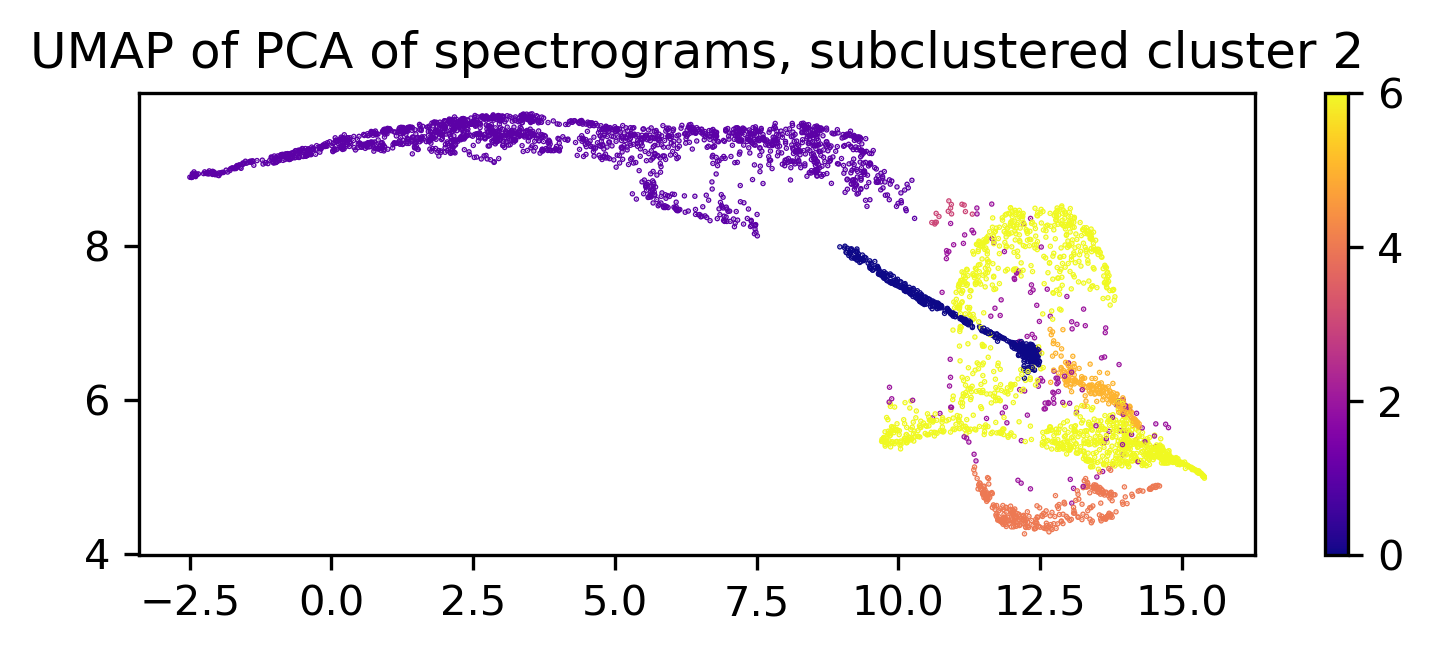

In [16]:
# Now let's plot the whole thing again
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='plasma')
plt.title('UMAP of PCA of spectrograms, subclustered cluster 2')
plt.colorbar()



Number of clusters: 7
Cluster 0 has 20 members


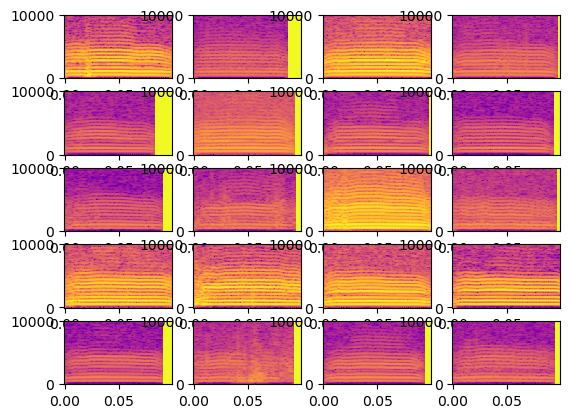

Cluster 1 has 20 members


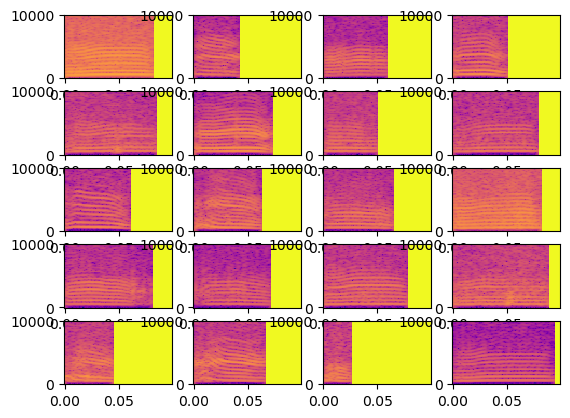

Cluster 2 has 20 members


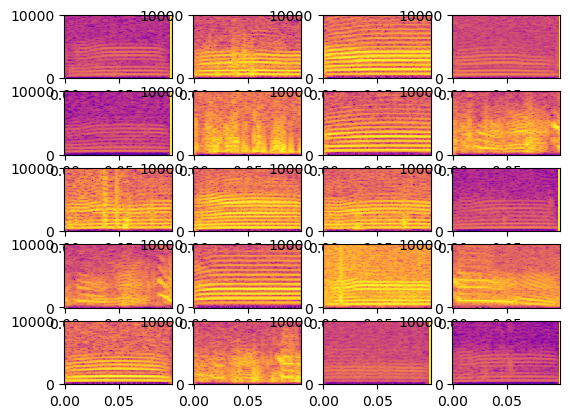

Cluster 3 has 15 members


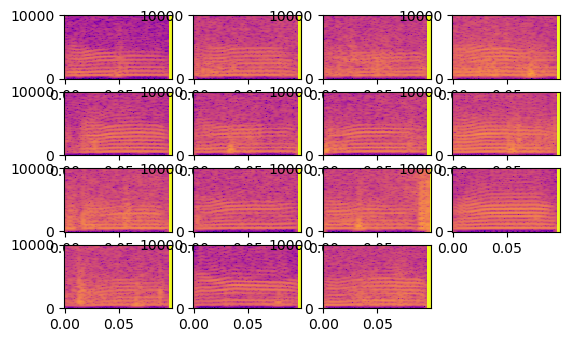

Cluster 4 has 20 members


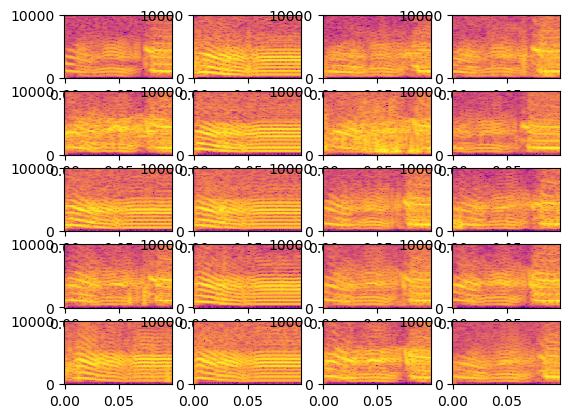

Cluster 5 has 20 members


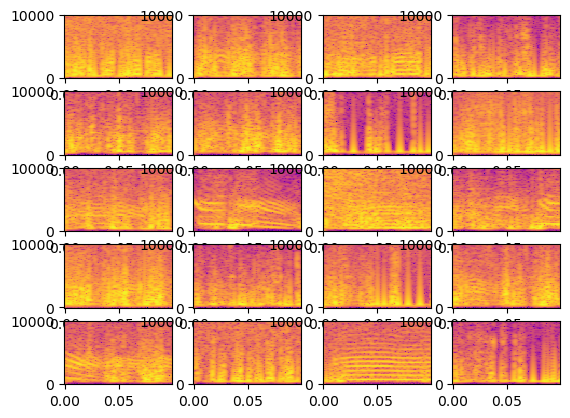

Cluster 6 has 20 members


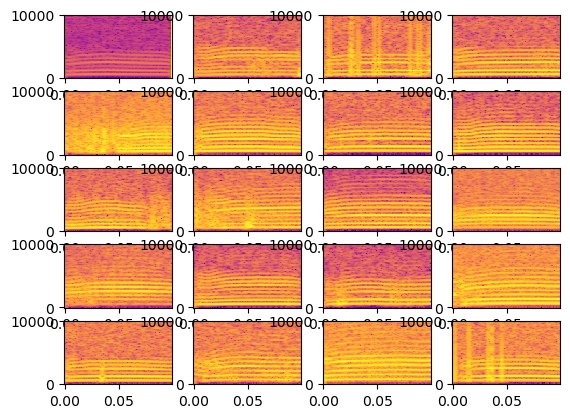

In [17]:
# Now let's look at some spectrograms from each cluster
# We'll take the first 20 from each cluster and plot them
# loop through the clusters and plot the first 20 spectrograms from each cluster using the index from the original data

# get the number of clusters
num_clusters = len(np.unique(clusterer.labels_))
print(f'Number of clusters: {num_clusters}')
# loop through the clusters and plot the first 20 spectrograms from each cluster using the index from the original data
for i in range(num_clusters):
    clusterInd = np.where(clusterer.labels_ == i)
    if len(clusterInd[0]) > 20:
        clusterInd = clusterInd[0][:20]
    else:
        clusterInd = clusterInd[0]
    plt.figure()
    print(f'Cluster {i} has {len(clusterInd)} members')
    for j, ind in enumerate(clusterInd):
        plt.subplot(5,4,j+1)
        plt.pcolormesh(time_bins, freq_bins, X[ind,:,:], cmap='plasma', shading='auto')
        # plt.title(f'Cluster {i}, index {ind}')
        
    plt.show()

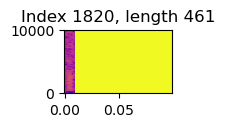

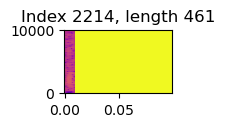

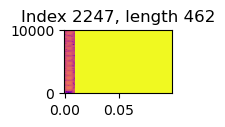

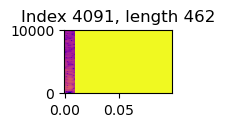

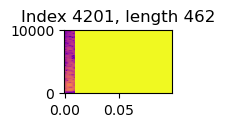

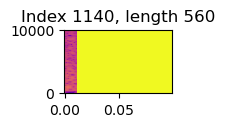

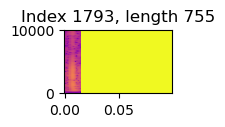

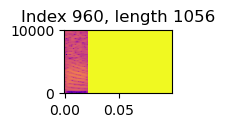

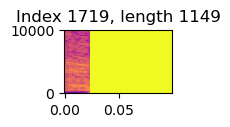

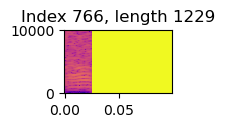

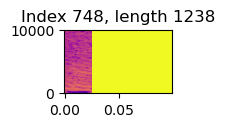

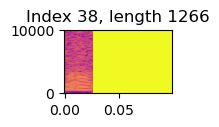

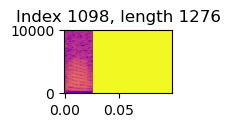

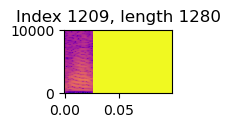

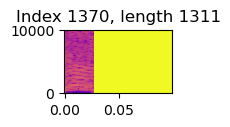

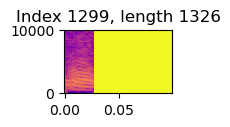

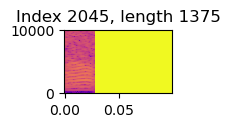

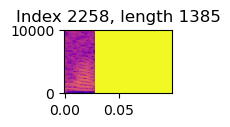

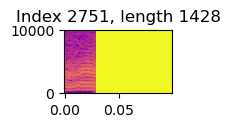

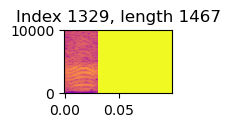

In [27]:
# This cell shows my spectrograms are in the right order in this notebook. 
# So no I've got to figure out why they aren't in the right order in the other notebook.

shortest_calls = np.argsort(lengths)
plt.figure()

for i in range(20):
    plt.subplot(5,4,i+1)    
    plt.pcolormesh(time_bins, freq_bins, X[shortest_calls[i],:,:], cmap='plasma', shading='auto')
    plt.title(f'Index {shortest_calls[i]}, length {lengths[shortest_calls[i]]}')
    plt.show()  

In [26]:
shortest_calls

array([1820, 2214, 2247, ...,  335, 3580, 3037])

In [19]:
# save the spectrograms to a file
np.save(os.path.join(base_folder,'spec_results','spectrograms.npy'), X)
# save the cluster labels and umap coords to a file
np.save(os.path.join(base_folder,'spec_results','cluster_labels.npy'), clusterer.labels_)

# save the times and frequencies to a file
np.save(os.path.join(base_folder,'spec_results','time_bins.npy'), time_bins)
np.save(os.path.join(base_folder,'spec_results','freq_bins.npy'), freq_bins)

## ok what's immediately noticeable is that padding with zeros is not great.  
## We could pad with silence, potentially of variable time, or at least somewhat.. Which might help extend our dataset (?)
## Ideally we would model the silence and insert that. 
## While this is promising, I want to move onto more promising things, like capturing the context of vocalizations. So I'm going to leave this for now.